In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00


In [2]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 13.8 MB/s eta 0:00:00


In [3]:
pip install matplotlib

In [4]:
pip install torchvision

In [5]:
pip install scikit-learn


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import numpy as np

from torch_geometric.loader import DataLoader
import torch_geometric.nn as gnn
import torch.nn.functional as F
#from torch_geometric.nn import GATConv
#from torch_geometric.nn import SAGEConv, GraphSAGE
from torchvision.datasets import DatasetFolder
from torchmetrics.classification import MulticlassSpecificity
from torchmetrics import AUROC

from sklearn.model_selection import train_test_split


In [8]:
import torch
from torchvision.datasets import DatasetFolder

ds = DatasetFolder(
    root=r'/content/gdrive/MyDrive/Processed',
    loader=torch.load,
    extensions=('pt',)
)


In [9]:
train_ratio = 0.90
val_ratio = 0.10

# Calculate the sizes of each set
total_size = len(ds)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size
print(train_size,val_size)

1930 215


In [10]:
train_idx, valid_idx = train_test_split(np.arange(len(ds)),test_size=val_size, shuffle=True, stratify=ds.targets)

val_dataset = Subset(ds, valid_idx)
train_dataset = Subset(ds, train_idx)

In [11]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=32, drop_last=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32,shuffle=False)

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(3, 8, heads=8, dropout=0.2)
        self.conv2 = GATConv(8 * 8, 4, dropout=0.2)
        self.global_pool = gnn.global_mean_pool

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.global_pool(x, data.batch)
        return torch.log_softmax(x, dim=-1)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GAT(3,4).to(device)

In [14]:
from torch_geometric.nn import GATConv

In [15]:
class GAT(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GAT, self).__init__()
        self.conv1 = GATConv(3, 128, heads=4)
        self.lin1 = torch.nn.Linear(3, 4 * 128)
        self.conv2 = GATConv(4 * 128, 128, heads=4)
        self.lin2 = torch.nn.Linear(4 * 128, 4 * 128)
        self.conv3 = GATConv(4 * 128, 4, heads=6, concat=False)
        self.lin3 = torch.nn.Linear(4 * 128, 4)
        self.global_pool = gnn.global_mean_pool

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        x = self.global_pool(x, data.batch)
        return x

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(3,4).to(device)

In [17]:
name='new_GATrasp'
# give a name to ur model version

In [18]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.RMSprop(model.parameters(), lr=1e-3, eps=1e-08)
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
epochs = 100

In [19]:
loss_list = []
val_loss_list=[]
val_acc_list = []
train_acc_list = []

In [20]:
# checking if a presaved model exists, with pre trained weights
import os
import pickle
if os.path.exists(f'{name}.pt'):
    print("found already saved model")
    model = torch.load(f'{name}.pt')
    model.eval()

    # View the saved weights
    weights = model.state_dict()
    #print(weights)

    # loading previous loss and accuracy value logs
    with open(f'{name}_loss', "rb") as fp:
        loss_list = pickle.load(fp)

    with open(f'{name}_val', "rb") as fp:
        val_loss_list = pickle.load(fp)

    with open(f'{name}_acc', "rb") as fp:
        val_acc_list = pickle.load(fp)

else:
    print('Creating fresh Model')

Creating fresh Model


In [21]:
import torch
import torch.nn.functional as F

# Training function
def train(epoch_no):
    model.train()
    total_loss = 0.0
    for step, (data, y) in enumerate(train_loader):
        num_classes = 4  # Adjust this to the actual number of classes in your dataset

        # Adjust labels if they are in the range [1, num_classes] instead of [0, num_classes-1]
        if torch.max(y) == num_classes:
            y = y - 1

        # Validate that the class values are within the valid range [0, num_classes - 1]
        if torch.min(y) < 0 or torch.max(y) >= num_classes:
            raise ValueError(f"Class values must be in the range [0, {num_classes - 1}], but found min: {torch.min(y)}, max: {torch.max(y)}")

        # Move data and labels to the device
        data, y = data.to(device), y.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = criterion(output, y)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    return avg_loss

# Validation function
def validate(loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, y in loader:
            data, y = data.to(device), y.to(device)
            output = model(data)
            loss = criterion(output, y)
            val_loss += loss.item()

            # Get predictions and calculate accuracy
            pred = torch.argmax(output, dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    avg_loss = val_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Training loop
epochs = 100  # or however many epochs you need
loss_list = []
val_loss_list = []
val_acc_list = []
train_acc_list = []

# Assuming the model has already been defined and initialized
for epoch in range(epochs):
    loss = train(epoch)
    val_loss, val_acc = validate(val_loader)  # Passing the DataLoader as a positional argument
    _, train_acc = validate(train_loader)  # No keyword argument here either

    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    train_acc_list.append(train_acc)

    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.6f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Train Acc: {train_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/folder.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample = self.loader(path)


Epoch: 001, Loss: 1.138987, Val Loss: 1.1664, Val Acc: 0.5814, Train Acc: 0.5849
Epoch: 002, Loss: 0.953528, Val Loss: 0.9285, Val Acc: 0.6419, Train Acc: 0.6479
Epoch: 003, Loss: 0.900257, Val Loss: 0.9735, Val Acc: 0.6186, Train Acc: 0.6052
Epoch: 004, Loss: 0.883381, Val Loss: 0.8980, Val Acc: 0.6558, Train Acc: 0.6661
Epoch: 005, Loss: 0.907241, Val Loss: 0.8575, Val Acc: 0.6884, Train Acc: 0.6839
Epoch: 006, Loss: 0.848017, Val Loss: 0.8271, Val Acc: 0.6930, Train Acc: 0.6896
Epoch: 007, Loss: 0.847055, Val Loss: 0.7998, Val Acc: 0.7163, Train Acc: 0.6974
Epoch: 008, Loss: 0.788479, Val Loss: 0.8016, Val Acc: 0.7070, Train Acc: 0.7104
Epoch: 009, Loss: 0.806826, Val Loss: 0.7977, Val Acc: 0.7070, Train Acc: 0.7177
Epoch: 010, Loss: 0.761474, Val Loss: 0.8072, Val Acc: 0.6884, Train Acc: 0.7208
Epoch: 011, Loss: 0.740776, Val Loss: 0.7780, Val Acc: 0.7349, Train Acc: 0.7411
Epoch: 012, Loss: 0.730511, Val Loss: 0.8033, Val Acc: 0.7070, Train Acc: 0.7385
Epoch: 013, Loss: 0.710212, 

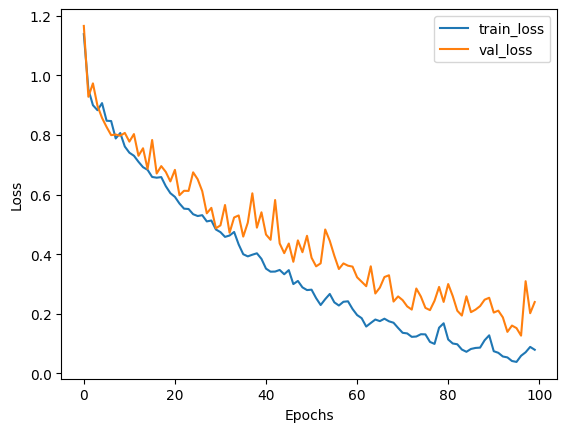

In [22]:
plt.plot(loss_list,label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

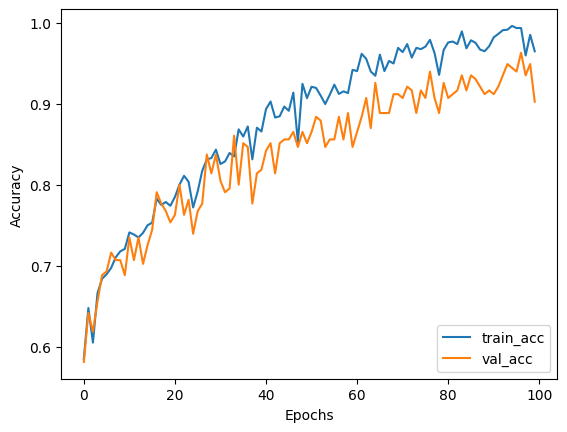

In [23]:
plt.plot(train_acc_list,label='train_acc')
plt.plot(val_acc_list,label='val_acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [24]:
torch.save(model, f'{name}.pt')
with open(f'{name}_loss', "wb") as fp:
    pickle.dump(loss_list,fp)

with open(f'{name}_val', "wb") as fp:
    pickle.dump(val_loss_list,fp)

with open(f'{name}_acc', "wb") as fp:
    pickle.dump(val_acc_list,fp)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
y_real = []
y_pred = []
y_scores = []
for i in val_dataset:
    y_real.append(i[1])
    out = model(i[0].to(device))
    _,pred = torch.max(out,1)
    y_scores.append(out)
    y_pred.append(int(pred))
print(classification_report(y_pred=y_pred,y_true=y_real))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        49
           1       0.90      0.98      0.94       114
           2       0.88      0.75      0.81        20
           3       0.92      0.75      0.83        32

    accuracy                           0.90       215
   macro avg       0.90      0.84      0.87       215
weighted avg       0.90      0.90      0.90       215



In [26]:
import matplotlib.pyplot as plt

Text(0.5, 23.52222222222222, 'Predicted label')

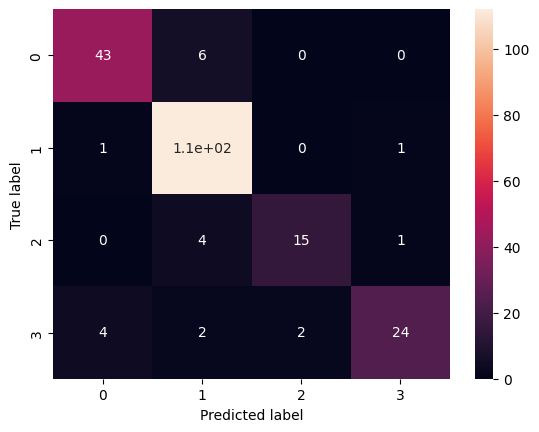

In [27]:
mat=confusion_matrix(y_pred=y_pred,y_true=y_real)
##print(mat)
import seaborn as sns

#labels = ["True Neg","False Pos","False Neg","True Pos"]
#labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mat, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [28]:
multiclass_metric = MulticlassSpecificity(num_classes=4, average=None)
specificity_values = multiclass_metric(torch.tensor(y_pred), torch.tensor(y_real)).tolist()
for idx, value in enumerate(specificity_values):
    print(f'specificity value for class {idx} is {value}')

specificity value for class 0 is 0.9698795080184937
specificity value for class 1 is 0.8811880946159363
specificity value for class 2 is 0.9897435903549194
specificity value for class 3 is 0.9890710115432739


In [29]:
sensitivity1 = mat[0,0]/(mat[0,0]+mat[0,1])
print('Sensitivity : ', sensitivity1)

specificity1 = mat[1,1]/(mat[1,0]+mat[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.8775510204081632
Specificity :  0.9911504424778761


torch.Size([215, 4])


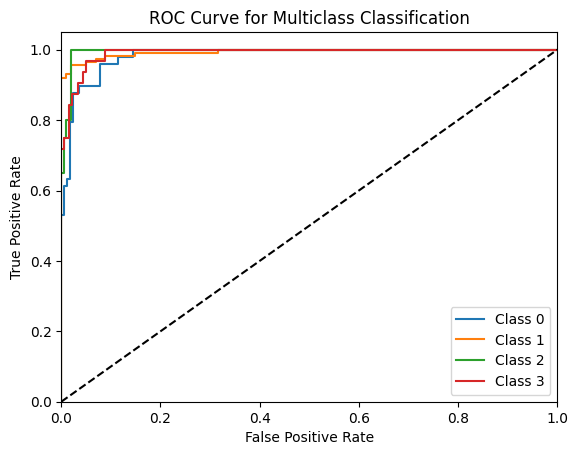

In [30]:
from torchmetrics.functional.classification import multiclass_roc
import matplotlib.pyplot as plt

# Get the number of classes
n_classes = len(np.unique(y_real))

prediction_tensor = torch.stack([t for t in y_scores]).view(-1,n_classes).to('cpu')
print(prediction_tensor.shape)

# Initialize variables to store false positive rate and true positive rate for each class
fpr, tpr, thresholds = multiclass_roc(preds=prediction_tensor, target=torch.tensor( y_real), num_classes=n_classes)

roc_auc = {}


plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i}' )

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

In [31]:
auroc = AUROC(task='multiclass', num_classes=4, average=None)
area_values = auroc(prediction_tensor, torch.tensor(y_real))
for idx, value in enumerate(area_values):
    print(f'area under ROC for class {idx} is {value}')

area under ROC for class 0 is 0.9835259914398193
area under ROC for class 1 is 0.9934861660003662
area under ROC for class 2 is 0.9948717355728149
area under ROC for class 3 is 0.9909495115280151
